<a href="https://colab.research.google.com/github/JoeL2002git/507_groupproject_2025/blob/main/part3_viz_individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymysql sqlalchemy pandas python-dotenv numpy matplotlib seaborn datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 14.8 MB/s eta 0:00:00


In [2]:
from sqlalchemy import create_engine
import pandas as pd
import os
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
load_dotenv(".env")

DB_HOST = os.getenv('DB_HOST')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_NAME = os.getenv('DB_NAME')
DB_TABLE = os.getenv('DB_TABLE')

url_string = f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:3306/{DB_NAME}"

conn = create_engine(url_string)

table = "research_experiment_refactor_test"

# Define the selected metrics and join them into a single string and querying columns based on the metrics

In [61]:
METRICS = [
    'accel_load_accum',
    'Jump Height(m)',
    'Peak Propulsive Force(N)',
    'distance_total',
    'leftMaxForce',
    'rightMaxForce'
]

metrics_join = "','".join(METRICS)

query = f"""
select
    playername,
    team,
    metric,
    value,
    timestamp
from {table}
where metric in ('{metrics_join}')
  and value is not null
order by playername, metric, timestamp
"""

df = pd.read_sql(query, conn)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df

,playername,team,metric,value,timestamp
0,PLAYER_001,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",Jump Height(m),0.2283,2022-08-26 13:31:24
1,PLAYER_001,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",Jump Height(m),0.1976,2022-08-26 13:31:37
2,PLAYER_001,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",Jump Height(m),0.1095,2022-08-26 14:32:39
3,PLAYER_001,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",Jump Height(m),0.0709,2022-11-15 14:32:30
4,PLAYER_001,"Group: WLAX , Group: WLAX Spring '24, Team: SB...",Jump Height(m),0.2093,2023-09-19 13:22:20
...,...,...,...,...,...
154397,PLAYER_999,Team: Stony Brook Men's Basketball,Peak Propulsive Force(N),2729.0000,2024-02-14 21:03:48
154398,PLAYER_999,Team: Stony Brook Men's Basketball,Peak Propulsive Force(N),2602.0000,2024-02-21 20:48:00
154399,PLAYER_999,Team: Stony Brook Men's Basketball,Peak Propulsive Force(N),2669.0000,2024-02-21 20:48:11
154400,PLAYER_999,Team: Stony Brook Men's Basketball,Peak Propulsive Force(N),2788.0000,2024-02-27 19:33:53


In [53]:
df['playername'] = df['playername'].astype(str).str.strip()
df['metric'] = df['metric'].astype(str).str.strip()
df['team'] = df['team'].astype(str).str.strip()

# Select two athletes

In [54]:
athlete1 = "PLAYER_663"
athlete2 = "PLAYER_419"

# Create function to extract athlete with their metrics. Then show how many metric points each athlete has.

In [55]:
def get_athlete(df, athlete, metrics):
    df_a = df[
        (df['playername'] == athlete) &
        (df['metric'].isin(metrics))
    ].copy()

    df_a = df_a.sort_values("timestamp")
    return df_a

In [56]:
df_a1 = get_athlete(df, athlete1, METRICS)
df_a2 = get_athlete(df, athlete2, METRICS)

print(f"Athlete 1 ({athlete1}): {len(df_a1)} measurements")
print(f"Athlete 2 ({athlete2}): {len(df_a2)} measurements")
print(f"\nAthlete 1 metrics: {df_a1['metric'].unique()}")
print(f"Athlete 2 metrics: {df_a2['metric'].unique()}")

Athlete 1 (PLAYER_663): 54 measurements
Athlete 2 (PLAYER_419): 226 measurements

Athlete 1 metrics: ['leftMaxForce' 'rightMaxForce' 'Jump Height(m)'
 'Peak Propulsive Force(N)']
Athlete 2 metrics: ['Peak Propulsive Force(N)' 'Jump Height(m)' 'accel_load_accum'
 'distance_total']


# Athlete 1

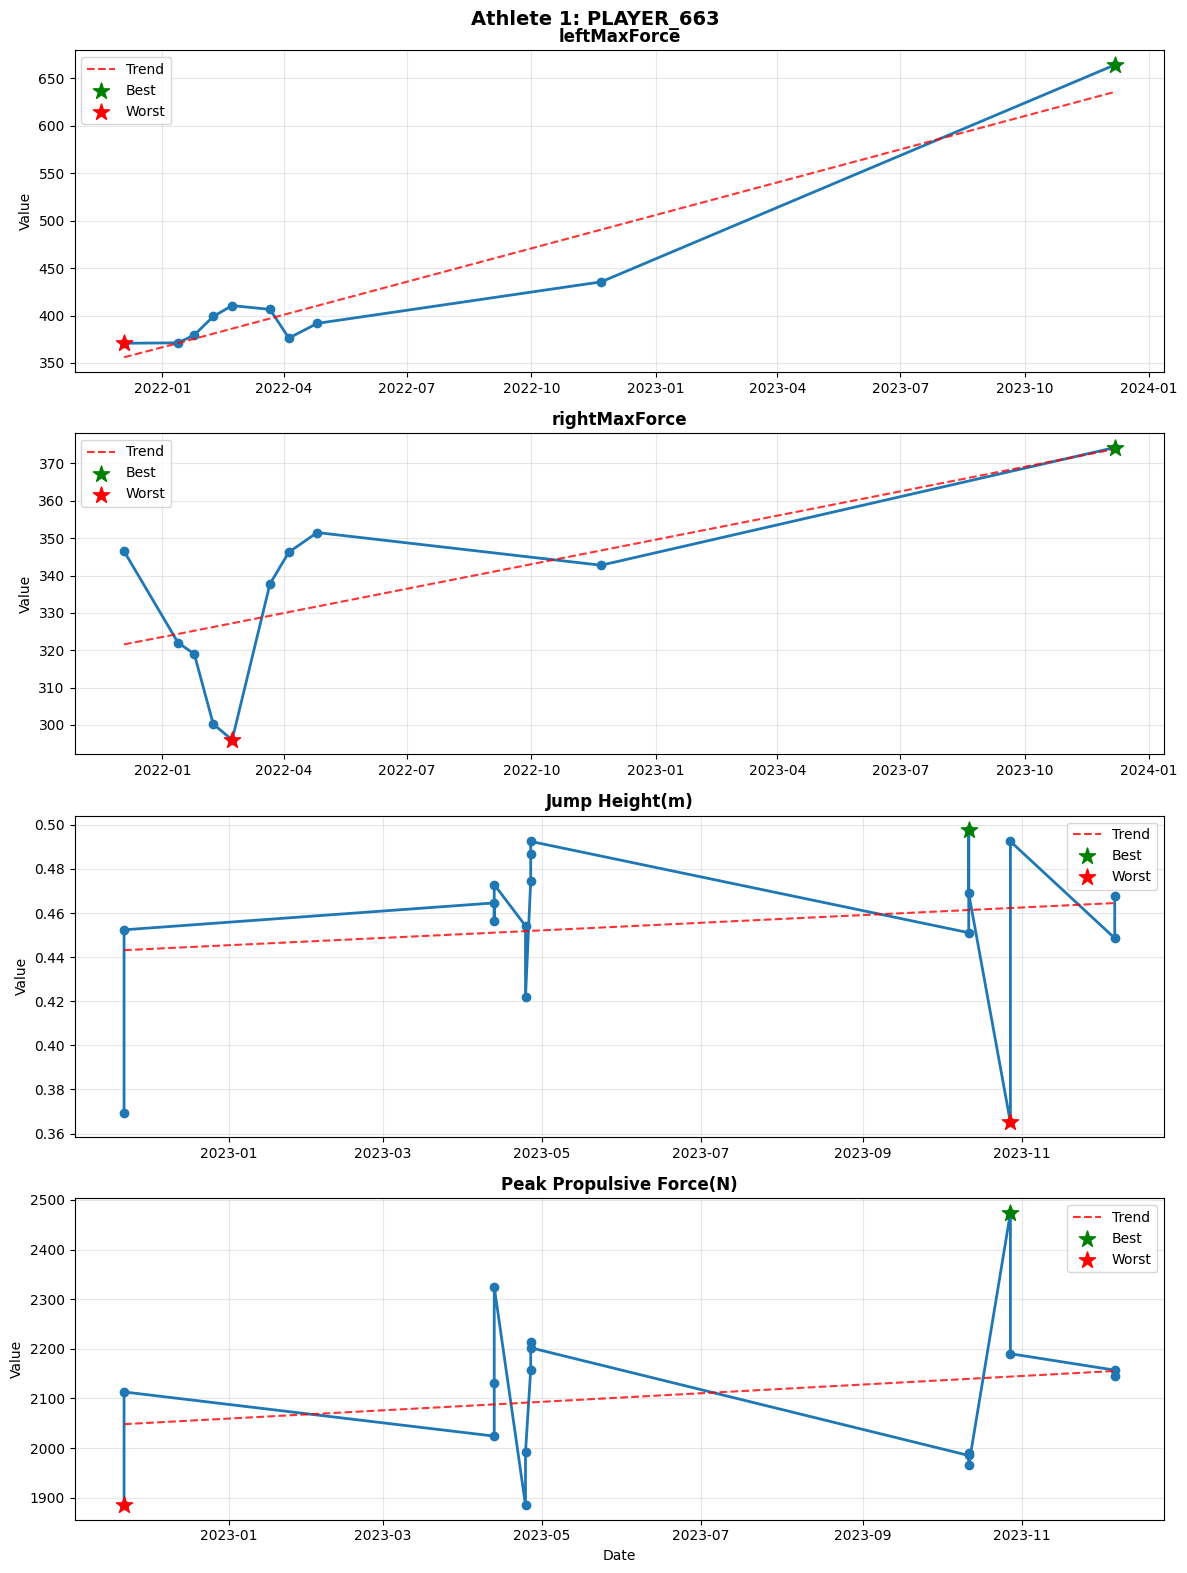

In [57]:
# Get unique metrics for athlete 1
a1_metrics = df_a1['metric'].unique()

# Create subplots
fig, axes = plt.subplots(len(a1_metrics), 1, figsize=(12, 4*len(a1_metrics)))
if len(a1_metrics) == 1:
    axes = [axes]

for i, metric in enumerate(a1_metrics):
    data = df_a1[df_a1['metric'] == metric]

    # Plot values over time
    axes[i].plot(data['timestamp'], data['value'], marker='o', linewidth=2)

    # Add trend line
    if len(data) >= 3:
        x = (data['timestamp'] - data['timestamp'].min()).dt.days
        z = np.polyfit(x, data['value'], 1)
        p = np.poly1d(z)
        axes[i].plot(data['timestamp'], p(x), "r--", alpha=0.8, label='Trend')

    # Mark best and worst values for each metric
    best_idx = data['value'].idxmax()
    worst_idx = data['value'].idxmin()
    axes[i].scatter(data.loc[best_idx, 'timestamp'], data.loc[best_idx, 'value'],
                   color='green', s=150, marker='*', zorder=5, label='Best')
    axes[i].scatter(data.loc[worst_idx, 'timestamp'], data.loc[worst_idx, 'value'],
                   color='red', s=150, marker='*', zorder=5, label='Worst')

    axes[i].set_title(f"{metric}", fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Creates time lablel
axes[-1].set_xlabel('Date')
fig.suptitle(f'Athlete 1: {athlete1}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [58]:
from scipy import stats as scipy_stats

print("="*60)
print(f"ATHLETE 1: {athlete1}")
print("="*60)

for metric in a1_metrics:
    data = df_a1[df_a1['metric'] == metric]
    values = data['value']

    # Shows general statistics for each metric
    print(f"\n{metric}:")
    print(f"  Count: {len(values)}")
    print(f"  Mean: {values.mean():.2f}")
    print(f"  Std: {values.std():.2f}")
    print(f"  Min: {values.min():.2f} on {data.loc[values.idxmin(), 'timestamp'].date()}")
    print(f"  Max: {values.max():.2f} on {data.loc[values.idxmax(), 'timestamp'].date()}")

    # Trend
    if len(data) >= 3:
        data_sorted = data.sort_values('timestamp')
        x = (data_sorted['timestamp'] - data_sorted['timestamp'].min()).dt.days
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, data_sorted['value'])

        first_val = data_sorted.iloc[0]['value']
        last_val = data_sorted.iloc[-1]['value']
        pct_change = ((last_val - first_val) / first_val) * 100

        print(f"  Trend: {slope:.4f} per day (p={p_value:.3f})")
        print(f"  Direction: {'Improving' if slope > 0 else 'Declining'}")

ATHLETE 1: PLAYER_663

leftMaxForce:
  Count: 10
  Mean: 420.52
  Std: 88.04
  Min: 370.75 on 2021-12-03
  Max: 664.25 on 2023-12-06
  Trend: 0.3823 per day (p=0.000)
  Direction: Improving

rightMaxForce:
  Count: 10
  Mean: 333.62
  Std: 24.21
  Min: 296.00 on 2022-02-21
  Max: 374.25 on 2023-12-06
  Trend: 0.0714 per day (p=0.042)
  Direction: Improving

Jump Height(m):
  Count: 17
  Mean: 0.46
  Std: 0.04
  Min: 0.36 on 2023-10-27
  Max: 0.50 on 2023-10-11
  Trend: 0.0001 per day (p=0.482)
  Direction: Improving

Peak Propulsive Force(N):
  Count: 17
  Mean: 2107.94
  Std: 154.92
  Min: 1885.00 on 2022-11-21
  Max: 2474.00 on 2023-10-27
  Trend: 0.2827 per day (p=0.382)
  Direction: Improving


# Athlete 2

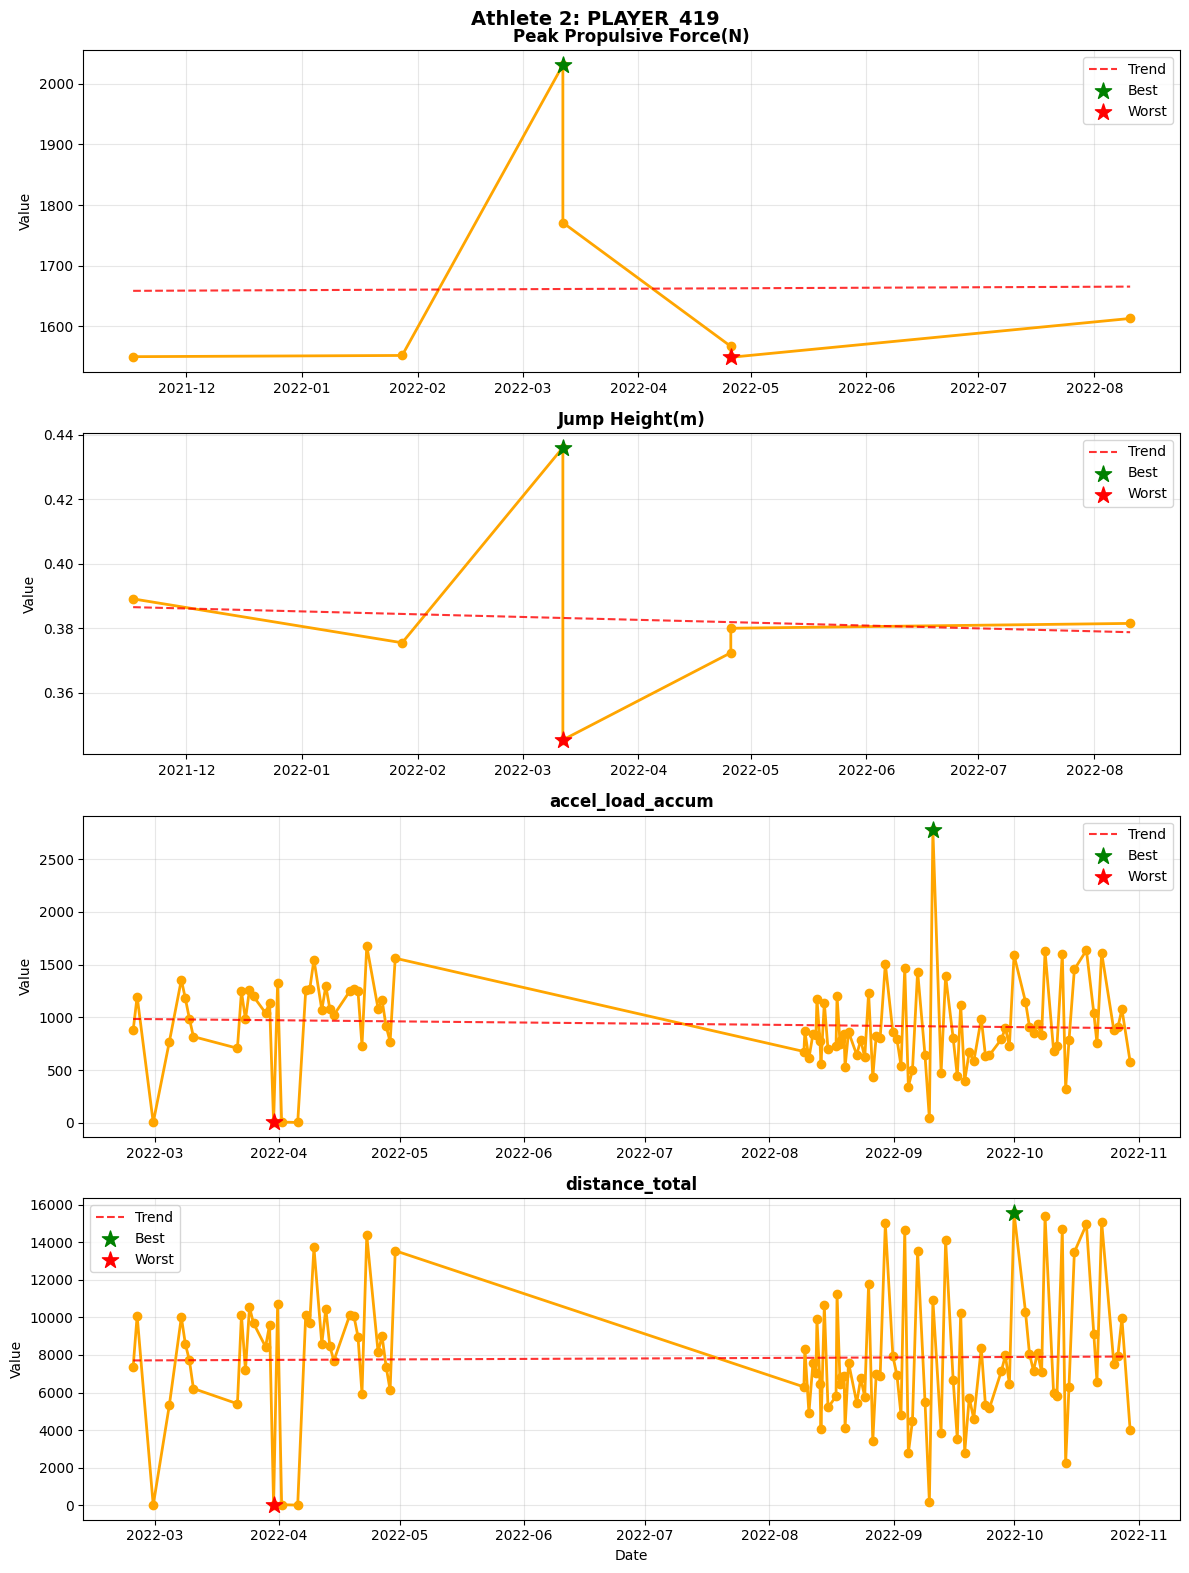

In [59]:
# Get unique metrics for athlete 2
a2_metrics = df_a2['metric'].unique()

# Create subplots
fig, axes = plt.subplots(len(a2_metrics), 1, figsize=(12, 4*len(a2_metrics)))
if len(a2_metrics) == 1:
    axes = [axes]

for i, metric in enumerate(a2_metrics):
    data = df_a2[df_a2['metric'] == metric]

    # Plot values over time
    axes[i].plot(data['timestamp'], data['value'], marker='o', linewidth=2, color='orange')

    # Add trend line
    if len(data) >= 3:
        x = (data['timestamp'] - data['timestamp'].min()).dt.days
        z = np.polyfit(x, data['value'], 1)
        p = np.poly1d(z)
        axes[i].plot(data['timestamp'], p(x), "r--", alpha=0.8, label='Trend')

    # Mark best and worst
    best_idx = data['value'].idxmax()
    worst_idx = data['value'].idxmin()
    axes[i].scatter(data.loc[best_idx, 'timestamp'], data.loc[best_idx, 'value'],
                   color='green', s=150, marker='*', zorder=5, label='Best')
    axes[i].scatter(data.loc[worst_idx, 'timestamp'], data.loc[worst_idx, 'value'],
                   color='red', s=150, marker='*', zorder=5, label='Worst')

    axes[i].set_title(f"{metric}", fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Set label for time
axes[-1].set_xlabel('Date')
fig.suptitle(f'Athlete 2: {athlete2}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [60]:
print(f"ATHLETE 2: {athlete2}")
print("="*60)

for metric in a2_metrics:
    data = df_a2[df_a2['metric'] == metric]
    values = data['value']

    # Shows general statistics for each metric
    print(f"\n{metric}:")
    print(f"  Count: {len(values)}")
    print(f"  Mean: {values.mean():.2f}")
    print(f"  Std: {values.std():.2f}")
    print(f"  Min: {values.min():.2f} on {data.loc[values.idxmin(), 'timestamp'].date()}")
    print(f"  Max: {values.max():.2f} on {data.loc[values.idxmax(), 'timestamp'].date()}")

    # Trend
    if len(data) >= 3:
        data_sorted = data.sort_values('timestamp')
        x = (data_sorted['timestamp'] - data_sorted['timestamp'].min()).dt.days
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, data_sorted['value'])

        first_val = data_sorted.iloc[0]['value']
        last_val = data_sorted.iloc[-1]['value']
        pct_change = ((last_val - first_val) / first_val) * 100

        print(f"  Trend: {slope:.4f} per day (p={p_value:.3f})")
        print(f"  Overall change: {pct_change:+.1f}%")
        print(f"  Direction: {'Improving' if slope > 0 else 'Declining'}")

ATHLETE 2: PLAYER_419

Peak Propulsive Force(N):
  Count: 7
  Mean: 1661.86
  Std: 181.14
  Min: 1549.00 on 2022-04-25
  Max: 2031.00 on 2022-03-11
  Trend: 0.0262 per day (p=0.980)
  Overall change: +4.1%
  Direction: Improving

Jump Height(m):
  Count: 7
  Mean: 0.38
  Std: 0.03
  Min: 0.35 on 2022-03-11
  Max: 0.44 on 2022-03-11
  Trend: -0.0000 per day (p=0.850)
  Overall change: -2.0%
  Direction: Declining

accel_load_accum:
  Count: 106
  Mean: 934.17
  Std: 420.98
  Min: 3.34 on 2022-03-30
  Max: 2776.03 on 2022-09-10
  Trend: -0.3515 per day (p=0.486)
  Overall change: -34.0%
  Direction: Declining

distance_total:
  Count: 106
  Mean: 7831.94
  Std: 3565.47
  Min: 0.12 on 2022-03-30
  Max: 15577.45 on 2022-09-30
  Trend: 0.8415 per day (p=0.844)
  Overall change: -45.8%
  Direction: Improving


# Interpretation

## Athlete 1

### Athlete 1 showed overall improvement throughout time in all 4 metrics that they had recorded. However, there seemed to be some outlier values that became the lowest performance value for Jump Height and Peak Propulsive Force.

### The jump height difference does not match with the literature review which is surprising since the average jump height for this athlete is 0.46m. This shows that the jump height performance of this athlete is below average compared to both a female and male athelete ranging from 0.5m-0.6m and 0.6m-0.7m respectively.

### The left/right max force values indicate that the athlete is either left leg dominant or had an injury in their right leg causing an imbalance between the two legs in max force improvement throughout time. This matches with the literature review where the two legs have over a 15% imbalance which is problematic and may lead to performance drops.

### Although peak propulsive force shows some decreases and increases in values, but the overall trend is upwards. This indicates that the athlete has better running force during the push-off phase. This may also be correlated with the increase in left/right max force of the legs.

## Athlete 2

### Athlete 2 showed some improvements and some downgrades in performance. The athlete improved in peak propulsive force and distance total. However, the there was a decline in value in jump height and accumulated acceleration load.

### Peak propulsive force showed an overall uptrend. This indicates an improvement in the push-off phase of a run. There is an outlier resulting in a top value of 2031 but after that the values went back to the average.

### Jump height had an overall decline in value. One interesting thing is that the top value was recorded the same day as the top value of peak propulsive force meaning that both outliers happened on the same day.

### Accumulated acceleration load had an overall decline. This means that the athlete experienced less muscular stress over time during training sessions.

### The distance total had an overall increase. This indicates that the athlete had an increase in travel distande throughout training sessions. This could be correlated with peak propulsive force where the more distance traveled led to the athlete improving in peak propulsive force.